# Emotion Detection from Text using LSTM

## 1. Introduction
**Objective**: Build a deep learning model to classify the emotion of a given text message.

**Dataset**: We will use the [dair-ai/emotion](https://huggingface.co/datasets/dair-ai/emotion) dataset (formerly typical of Twitter data). It contains English Twitter messages labeled with six emotions:
- Anger
- Fear
- Joy
- Love
- Sadness
- Surprise

**Architecture**:
- **Embedding Layer**: Converts words into dense vectors.
- **Bidirectional LSTM Layers**: Captures context from both directions (past and future).
- **Dense Layers**: For classification.

## 2. Setup and Imports
Checking for GPU availability and installing necessary libraries.

In [ ]:
# Install Hugging Face datasets library if not already installed
!pip install datasets seaborn matplotlib scikit-learn tensorflow wget --quiet

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from datasets import load_dataset
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Bidirectional, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import os
import wget

# Set seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

print("TensorFlow Version:", tf.__version__)
print("GPU Available:", "Yes" if tf.config.list_physical_devices('GPU') else "No")

TensorFlow Version: 2.19.0
GPU Available: Yes


## 3. Data Loading
We use the `datasets` library to easily load the emotion dataset.

In [ ]:
# Load the dataset
dataset = load_dataset("dair-ai/emotion")

# View dataset structure
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})


In [ ]:
# Convert to Pandas DataFrames for easier manipulation
train_df = pd.DataFrame(dataset['train'])
val_df = pd.DataFrame(dataset['validation'])
test_df = pd.DataFrame(dataset['test'])

# Check first few rows
print(train_df.head())

                                                text  label
0                            i didnt feel humiliated      0
1  i can go from feeling so hopeless to so damned...      0
2   im grabbing a minute to post i feel greedy wrong      3
3  i am ever feeling nostalgic about the fireplac...      2
4                               i am feeling grouchy      3


In [ ]:
# Define Label Mapping (Dynamic)
labels = dataset['train'].features['label'].names
label_map = {i: label for i, label in enumerate(labels)}
print("Label Mapping:", label_map)

# Add a 'label_name' column for readability
train_df['label_name'] = train_df['label'].map(label_map)
val_df['label_name'] = val_df['label'].map(label_map)
test_df['label_name'] = test_df['label'].map(label_map)

train_df.head()

Label Mapping: {0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}


,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


## 4. Exploratory Data Analysis (EDA)
Understanding the distribution of emotions and text length.

/tmp/ipython-input-1361276476.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=train_df, x='label_name', order=train_df['label_name'].value_counts().index, palette='viridis')


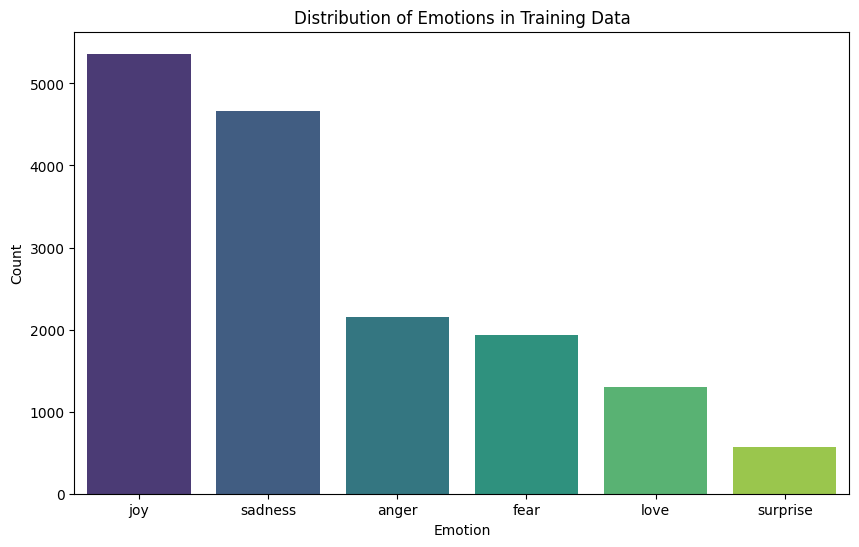

In [ ]:
# Plot Class Distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=train_df, x='label_name', order=train_df['label_name'].value_counts().index, palette='viridis')
plt.title('Distribution of Emotions in Training Data')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.show()

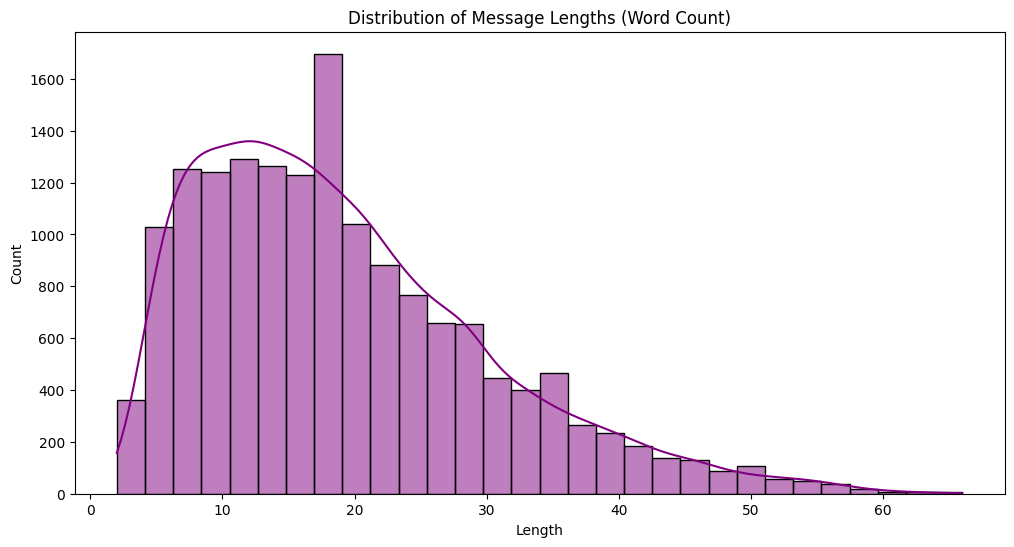

Max length: 66
Average length: 19.17


In [ ]:
# Analyze Text Length
train_df['text_length'] = train_df['text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(12, 6))
sns.histplot(train_df['text_length'], kde=True, bins=30, color='purple')
plt.title('Distribution of Message Lengths (Word Count)')
plt.xlabel('Length')
plt.show()

print(f"Max length: {train_df['text_length'].max()}")
print(f"Average length: {train_df['text_length'].mean():.2f}")

## 5. Data Preprocessing
1. **Tokenization**: Converting words to integers.
2. **Padding**: Ensuring all sequences are the same length.
3. **Encoding Labels**: Preparing target variables.

In [ ]:
# Parameters
VOCAB_SIZE = 10000  # Max number of words to keep
MAX_LEN = 60        # Max length of sequences (based on EDA ~50)
OOV_TOKEN = "<OOV>" # Token for out-of-vocabulary words

# Initialize Tokenizer with strict filters to handle contractions (e.g., I'm -> I m)
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token=OOV_TOKEN, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\'')
tokenizer.fit_on_texts(train_df['text'])

# Convert text to sequences
train_sequences = tokenizer.texts_to_sequences(train_df['text'])
val_sequences = tokenizer.texts_to_sequences(val_df['text'])
test_sequences = tokenizer.texts_to_sequences(test_df['text'])

# Pad sequences
X_train = pad_sequences(train_sequences, maxlen=MAX_LEN, padding='post', truncating='post')
X_val = pad_sequences(val_sequences, maxlen=MAX_LEN, padding='post', truncating='post')
X_test = pad_sequences(test_sequences, maxlen=MAX_LEN, padding='post', truncating='post')

# Prepare Labels (Categorical)
y_train = tf.keras.utils.to_categorical(train_df['label'], num_classes=6)
y_val = tf.keras.utils.to_categorical(val_df['label'], num_classes=6)
y_test = tf.keras.utils.to_categorical(test_df['label'], num_classes=6)

print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)

Shape of X_train: (16000, 60)
Shape of y_train: (16000, 6)


## 6. GloVe Embeddings
Downloading and preparing pre-trained GloVe embeddings to provide semantic context.

In [ ]:
# Download GloVe embeddings (100d)
if not os.path.exists('glove.6B.100d.txt'):
    print('Downloading GloVe embeddings...')
    url = 'http://nlp.stanford.edu/data/glove.6B.zip'
    wget.download(url)
    !unzip -q glove.6B.zip

# Create Embedding Index
embeddings_index = {}
with open('glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print(f'Found {len(embeddings_index)} word vectors.')

# Create Embedding Matrix
word_index = tokenizer.word_index
embedding_matrix = np.zeros((VOCAB_SIZE, 100))
for word, i in word_index.items():
    if i < VOCAB_SIZE:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

print(f'Embedding matrix shape: {embedding_matrix.shape}')

Found 400000 word vectors.
Embedding matrix shape: (10000, 100)


## 7. Class Weights
Handling imbalance by assigning higher weights to minority classes.

In [ ]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['label']),
    y=train_df['label']
)
class_weight_dict = dict(enumerate(class_weights))
print("Class Weights:", class_weight_dict)

Class Weights: {0: np.float64(0.5715102157451064), 1: np.float64(0.49732686808404825), 2: np.float64(2.044989775051125), 3: np.float64(1.2351397251814111), 4: np.float64(1.3766993632765445), 5: np.float64(4.662004662004662)}


## 8. Building the LSTM Model
We use a **Bidirectional LSTM**. Bidirectional LSTMs train two LSTMs on the input sequence: one on the input sequence as-is, and another on a reversed copy. This provides more context.

**Structure**:
1. **Embedding**: Maps word indices to 100-dim vectors.
2. **Bi-LSTM (64 units)**: Returns sequences for the next layer.
3. **Bi-LSTM (32 units)**: Abstract features.
4. **Dense & Dropout**: For classification and preventing overfitting.

In [ ]:
EMBEDDING_DIM = 100

model = Sequential([
    Input(shape=(MAX_LEN,)),
    Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, weights=[embedding_matrix], trainable=True),
    Bidirectional(LSTM(64, return_sequences=True)),
    BatchNormalization(),
    Dropout(0.3),
    Bidirectional(LSTM(32)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(6, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 60, 100)        │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 60, 128)        │        84,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 60, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,131,014 (4.31 MB)

 Trainable params: 1,130,630 (4.31 MB)

 Non-trainable params: 384 (1.50 KB)

## 9. Model Training
We use `EarlyStopping` to stop training when validation loss stops improving.

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=15,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    class_weight=class_weight_dict,
    verbose=1
)

Epoch 1/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - accuracy: 0.2043 - loss: 1.9740 - val_accuracy: 0.4925 - val_loss: 1.1920 - learning_rate: 0.0010
Epoch 2/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.4892 - loss: 1.1078 - val_accuracy: 0.8310 - val_loss: 0.5187 - learning_rate: 0.0010
Epoch 3/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.8447 - loss: 0.4472 - val_accuracy: 0.9035 - val_loss: 0.2865 - learning_rate: 0.0010
Epoch 4/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.8956 - loss: 0.3024 - val_accuracy: 0.9145 - val_loss: 0.2873 - learning_rate: 0.0010
Epoch 5/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.9198 - loss: 0.2284 - val_accuracy: 0.9230 - val_loss: 0.2615 - learning_rate: 0.0010
Epoch 6/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9282 - loss: 0.2050 - val_accuracy: 0.9280 - val_loss: 0.2256 - learning_rate: 0.0010
Epoch 7/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.9423 - loss:

## 10. Evaluation
Visualizing the training performance and evaluating on the test set.

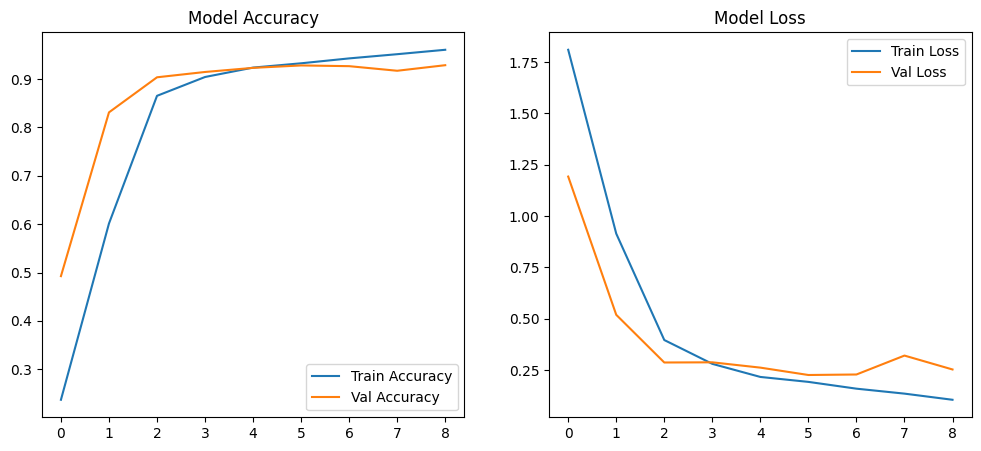

In [ ]:
# Plot Accuracy and Loss
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.legend()

plt.show()

In [ ]:
# Evaluate on Test Data
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9250 - loss: 0.2506
Test Accuracy: 0.9225


In [ ]:
# Classification Report
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

print(classification_report(y_true, y_pred, target_names=label_map.values()))

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
              precision    recall  f1-score   support

     sadness       0.98      0.95      0.96       581
         joy       0.97      0.92      0.94       695
        love       0.74      0.94      0.83       159
       anger       0.94      0.92      0.93       275
        fear       0.91      0.86      0.89       224
    surprise       0.66      0.95      0.78        66

    accuracy                           0.92      2000
   macro avg       0.87      0.92      0.89      2000
weighted avg       0.93      0.92      0.92      2000



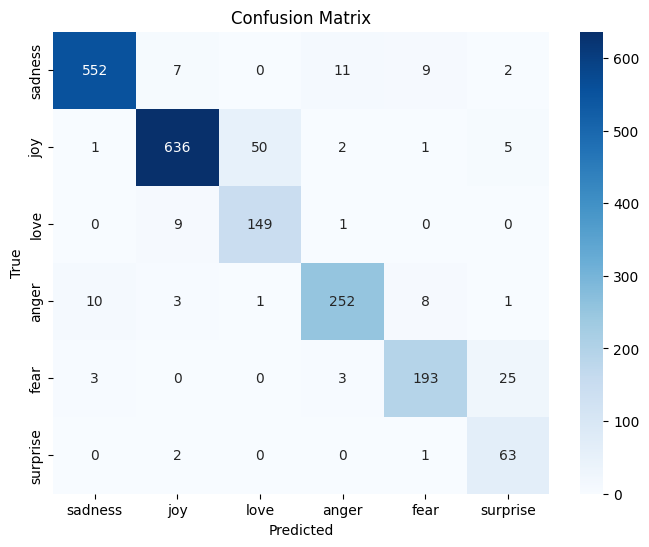

In [ ]:
# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_map.values(), yticklabels=label_map.values())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## 11. Inference
Test the model with custom input sentences.

In [ ]:
def predict_emotion(text):
    # Preprocess
    seq = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(seq, maxlen=MAX_LEN, padding='post', truncating='post')

    # Predict
    pred_prob = model.predict(padded)
    pred_label = np.argmax(pred_prob)

    return label_map[pred_label], pred_prob

def debug_prediction(text):
    seq = tokenizer.texts_to_sequences([text])
    print(f"Original: {text}")
    print(f"Tokenized: {seq}")
    print(f"Decoded: {tokenizer.sequences_to_texts(seq)}")
    return predict_emotion(text)

# Test examples
examples = [
    "I felt absolutely crushed when I heard the news.",
    "I am so excited about the upcoming trip!",
    "Why does this always happen to me? It's so frustrating!",
    "I'm really afraid of what might happen next.",
    "The party was a complete surprise!",
    "I really love spending time with you."
]

for text in examples:
    emotion, _ = predict_emotion(text)
    print(f"Text: {text} | Predicted Emotion: {emotion}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Text: I felt absolutely crushed when I heard the news. | Predicted Emotion: sadness
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Text: I am so excited about the upcoming trip! | Predicted Emotion: joy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Text: Why does this always happen to me? It's so frustrating! | Predicted Emotion: sadness
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Text: I'm really afraid of what might happen next. | Predicted Emotion: fear
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Text: The party was a complete surprise! | Predicted Emotion: joy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Text: I really love spending time with you. | Predicted Emotion: joy


## 12. Conclusion
We successfully built a Bidirectional LSTM model for emotion detection.

**Further Improvements:**
- Use **Pre-trained Embeddings** like GloVe or Word2Vec for better semantic understanding.
- Use **Transformer models** (BERT, RoBERTa) for state-of-the-art performance.
- **Data Augmentation** to handle class imbalance (though `dair-ai/emotion` is relatively balanced).